In [1]:
# uci_digits_auto_anomaly.py

# autoencoder reconstruction error anomaly detection
# uses an encoder-decoder architecture
# PyTorch 1.8.0-CPU Anaconda3-2020.02  Python 3.7.6
# Windows 10 

import numpy as np
import matplotlib.pyplot as plt
import torch as T

device = T.device("cpu") 
print(device)

cpu


In [2]:
# -----------------------------------------------------------

class UCI_Digits_Dataset(T.utils.data.Dataset):
  # 8,12,0,16, . . 15,7
  # 64 pixel values [0-16], digit [0-9]

  def __init__(self, src_file, n_rows=None):
    all_xy = np.loadtxt(src_file, max_rows=n_rows,
      usecols=range(0,65), delimiter=",", comments="#",
      dtype=np.float32)
    self.xy_data = T.tensor(all_xy, dtype=T.float32).to(device) 
    self.xy_data[:, 0:64] /= 16.0   # normalize pixels
    self.xy_data[:, 64] /= 9.0      # normalize digit/label

  def __len__(self):
    return len(self.xy_data)

  def __getitem__(self, idx):
    xy = self.xy_data[idx]
    return xy

# -----------------------------------------------------------

In [3]:
# -----------------------------------------------------------

class Autoencoder(T.nn.Module):  # 65-32-8-32-65
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.fc1 = T.nn.Linear(65, 32)
    self.fc2 = T.nn.Linear(32, 8)
    self.fc3 = T.nn.Linear(8, 32)
    self.fc4 = T.nn.Linear(32, 65)

  def encode(self, x):  # 65-32-8
    z = T.tanh(self.fc1(x))
    z = T.tanh(self.fc2(z))  # latent in [-1,+1]
    return z  

  def decode(self, x):  # 8-32-65
    z = T.tanh(self.fc3(x))
    z = T.sigmoid(self.fc4(z))  # [0.0, 1.0]
    return z
    
  def forward(self, x):
    z = self.encode(x) 
    z = self.decode(z) 
    return z  # in [0.0, 1.0]

# -----------------------------------------------------------


In [4]:
# -----------------------------------------------------------

def display_digit(ds, idx, save=False):
  # ds is a PyTorch Dataset
  line = ds[idx]  # tensor
  pixels = np.array(line[0:64])  # numpy row of pixels
  label = np.int_(line[64] * 9.0)  # denormalize; like '5'
  print("\ndigit = ", str(label), "\n")

  pixels = pixels.reshape((8,8))
  for i in range(8):
    for j in range(8):
      pxl = pixels[i,j]  # or [i][j] syntax
      pxl = np.int_(pxl * 16.0)  # denormalize
      print("%.2X" % pxl, end="")
      print(" ", end="")
    print("")

  plt.imshow(pixels, cmap=plt.get_cmap('gray_r'))
  if save == True:
    plt.savefig(".\\idx_" + str(idx) + "_digit_" + \
    str(label) + ".jpg", bbox_inches='tight')
  plt.show() 
  plt.close() 

# -----------------------------------------------------------



In [5]:

def display_digits(ds, idxs, save=False):
  # idxs is a list of indices
  for idx in idxs:
    display_digit(ds, idx, save)

# -----------------------------------------------------------

In [6]:

def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")

# -----------------------------------------------------------


In [7]:

def make_err_list(model, ds):
  # assumes model.eval()
  result_lst = []
  n_features = len(ds[0])  # 65
  for i in range(len(ds)):
    X = ds[i]
    with T.no_grad():
      Y = model(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    err = err / n_features           # sort of norm'ed SSE 
    result_lst.append( (i,err) )     # idx of data item, err
  return result_lst 

# -----------------------------------------------------------

In [8]:
# 0. get started
print("\nBegin UCI Digits autoencoder anomaly demo ")
T.manual_seed(1)
np.random.seed(1)

# 1. create Dataset object
print("\nLoading data as normalized tensors ")
fn = ".\\Data\\optdigits_train_3823.txt"
data_ds = UCI_Digits_Dataset(fn)  # all rows



Begin UCI Digits autoencoder anomaly demo 

Loading data as normalized tensors 


In [9]:
print(type(data_ds.__getitem__(1125)))
print(len(data_ds))

<class 'torch.Tensor'>
3823


In [10]:
def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")


In [11]:

# 2. create autoencoder net
print("\nCreating a 65-32-8-32-65 autoencoder ")
autoenc = Autoencoder().to(device)
autoenc.train()   # set mode




Creating a 65-32-8-32-65 autoencoder 


Autoencoder(
  (fc1): Linear(in_features=65, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=65, bias=True)
)

In [12]:
bat_size = 10

data_ldr = T.utils.data.DataLoader(data_ds, batch_size=bat_size, shuffle=True)

In [13]:
print(len(data_ldr)) 

383


Above is 383 because there were in total 3823 elements in the dataset (see "len(data_ds)"). And as this variable (data_ldr) is storing batches of data; each one of them of length 10, it only has the size of 383. Meaning that the last batch might contain only 3 elements instead of 10.

In [14]:
# bat_size = 10
# lrn_rate = 0.005
# max_epochs = 100
# log_interval = 10


# data_ldr = T.utils.data.DataLoader(data_ds, batch_size=bat_size, shuffle=True)




# loss_func = T.nn.MSELoss()
# opt = T.optim.SGD(autoenc.parameters(), lr=lrn_rate)
# print("\nStarting training")
# for epoch in range(0, max_epochs):
#     epoch_loss = 0.0
#     for (batch_idx, batch) in enumerate(data_ldr):
#         X = batch  # inputs
#         Y = batch  # targets (same as inputs)

#         opt.zero_grad()                # prepare gradients
#         oupt = autoenc(X)                   # compute output/target
#         loss_val = loss_func(oupt, Y)  # a tensor
#         epoch_loss += loss_val.item()  # accumulate for display
#         loss_val.backward()            # compute gradients
#         opt.step()                     # update weights

#     if epoch % log_interval == 0:
#         print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
# print("Done ")


In [15]:
# 3. train autoencoder model
bat_size = 10
max_epochs = 100
log_interval = 10
lrn_rate = 0.005

print("\nbat_size = %3d " % bat_size)
print("max epochs = " + str(max_epochs))
print("loss = MSELoss")
print("optimizer = SGD")
print("lrn_rate = %0.3f " % lrn_rate)






bat_size =  10 
max epochs = 100
loss = MSELoss
optimizer = SGD
lrn_rate = 0.005 


In [16]:
# train(autoenc, data_ds, bat_size, max_epochs, \
# log_interval, lrn_rate) 

In [17]:
filepath = "../../../BottlesAnomalies_TFM/models/pytorchModels/UCI_digitsModel1"


In [18]:
# T.save(autoenc.state_dict(), filepath)

In [19]:
# For loading the model 
autoenc.load_state_dict(T.load(filepath))
autoenc.eval()

Autoencoder(
  (fc1): Linear(in_features=65, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=65, bias=True)
)

# Comparison between the reconstructed and input data 

After training we will see the tensor max and min values of both, the input data and the reconstructed one.


In [20]:
print("The input data treated through batches")
images = next(iter(data_ldr))
print("The len of each batch is: ", len(images))
print("The images are stored in a variable of type: ", type(images))
print("The min and max tensor values of the input is: ", T.min(images), T.max(images))
print("\n")
print("The reconstructed data treated through batches")
recon_output = autoenc(images)
print("The recontructed images are stored in a variable of type: ", type(recon_output))
print("The min and max tensor values of the reconstruction is: ", T.min(recon_output), T.max(recon_output))

The input data treated through batches
The len of each batch is:  10
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.) tensor(1.)


The reconstructed data treated through batches
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0675, grad_fn=<MinBackward1>) tensor(0.7491, grad_fn=<MaxBackward1>)


The tensor dimensions of both, the input and reconstruction data don't match. Try this:

In [21]:
print("The input data treated through batches")
images = next(iter(data_ldr))
print("The len of each batch is: ", len(images))
print("The images are stored in a variable of type: ", type(images))
print("The min and max tensor values of the input is: ", T.min(images), T.max(images))
print("\n")
print("The reconstructed data treated through batches")
with T.no_grad():       # Because gradients will not be computed
    recon_output = autoenc(images)
print("The recontructed images are stored in a variable of type: ", type(recon_output))
print("The min and max tensor values of the reconstruction is: ", T.min(recon_output), T.max(recon_output))

The input data treated through batches
The len of each batch is:  10
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.) tensor(1.)


The reconstructed data treated through batches
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0676) tensor(0.7492)


Now, the dimensions match. Using the "T.no_grad()" function is imporant for this.

Finally, this entire program example does not use the input data by batches to compute the error of the reconstructed data, but computes it using one by one sample of the input data. See the following:

In [22]:
print("The input data considering only one sample. Not a batch of samples")
X = data_ds[0]
print("The images are stored in a variable of type: ", type(X))
print("The min and max tensor values of the input is: ", T.min(X), T.max(X))
print("\n")
print("The reconstructed data onsidering only one sample. Not a batch of samples")
with T.no_grad():       # Because gradients will not be computed
    Y = autoenc(X)
print("The recontructed images are stored in a variable of type: ", type(Y))
print("The min and max tensor values of the reconstruction is: ", T.min(Y), T.max(Y))

The input data considering only one sample. Not a batch of samples
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.) tensor(1.)


The reconstructed data onsidering only one sample. Not a batch of samples
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0707) tensor(0.7461)


See above that the tnesor max and min values of the input and reconstruction data are not the same, but somehow close to each other. This is expected as the reconstruction is not 100% the same as the input data.

# Step by step computing the recon error 

In [23]:
X = data_ds[0]
with T.no_grad():       # Because gradients will not be computed
    Y = autoenc(X)

err = T.sum((X-Y)*(X-Y))
print(err)
print(type(err))

err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
print(err)
print(type(err))

tensor(4.3747)
<class 'torch.Tensor'>
4.374675273895264
<class 'float'>


In [24]:
X = data_ds[0]
print(len(X))

65


Above we can see the difference between using ".item()" and not using it. 

And below, we can see why to use ".sum()" since we are computing the square of all the features or pixels that compose the image. 

In [25]:
print(X-Y)

print((X-Y)*(X-Y))

tensor([-0.0733, -0.0259,  0.0347,  0.1999,  0.0336, -0.2816, -0.1220, -0.0837,
        -0.0838,  0.2908,  0.3401, -0.3637, -0.2905,  0.1020, -0.1540, -0.0858,
        -0.0787,  0.3217,  0.3987, -0.2976, -0.4520,  0.1848, -0.0200, -0.0812,
        -0.0768,  0.1419,  0.4207, -0.3841, -0.6061, -0.1762,  0.2873, -0.0902,
        -0.0763,  0.2855,  0.3330, -0.3889, -0.6518, -0.0755,  0.2554, -0.0764,
        -0.0736,  0.1359,  0.3448, -0.4443, -0.4329,  0.2691,  0.0869, -0.0844,
        -0.0895, -0.1094,  0.3825, -0.0563,  0.3246, -0.0204, -0.2408, -0.0887,
        -0.0856, -0.0707,  0.0086,  0.1289, -0.2786, -0.3565, -0.1457, -0.0893,
        -0.4977])
tensor([5.3658e-03, 6.7018e-04, 1.2058e-03, 3.9962e-02, 1.1291e-03, 7.9285e-02,
        1.4892e-02, 7.0099e-03, 7.0211e-03, 8.4547e-02, 1.1569e-01, 1.3224e-01,
        8.4366e-02, 1.0414e-02, 2.3717e-02, 7.3682e-03, 6.1880e-03, 1.0350e-01,
        1.5900e-01, 8.8568e-02, 2.0435e-01, 3.4148e-02, 4.0195e-04, 6.6002e-03,
        5.9003e-03, 2.

Now, it will be necessary to divide this error quantity by the number of pixels. In this case we have 65 pixels or features of the image.

In [26]:
n_features = len(data_ds[0])  # 65
err = err / n_features           # sort of norm'ed SSE
print(err)
print(type(err))

0.06730269652146559
<class 'float'>


And finally we append this error value. This will be the reconstruction error corresponding to only the first image.
By appending the error values we will have a list of all the reconstruction errors corresponding to all the input images.

The entire function executed looks like this:

In [27]:

result_lst = []
n_features = len(data_ds[0])  # 65
for i in range(len(data_ds)):
    X = data_ds[i]
    with T.no_grad():
        Y = autoenc(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    err = err / n_features           # sort of norm'ed SSE 
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.06730269652146559), (1, 0.1013510117164025), (2, 0.08182017252995417), (3, 0.08907860975999099), (4, 0.06734959528996394), (5, 0.06519675621619592), (6, 0.06660180458655725), (7, 0.04982570501474234), (8, 0.08880249170156626), (9, 0.05827780503493089), (10, 0.11577253341674805), (11, 0.08436558063213642), (12, 0.0998289548433744), (13, 0.057325487870436447), (14, 0.05275339346665602), (15, 0.0769606296832745), (16, 0.07237437321589543), (17, 0.09564261803260217), (18, 0.05450827892010029), (19, 0.09791319920466496), (20, 0.09518712850717398), (21, 0.049089721532968374), (22, 0.06339110594529372), (23, 0.08078757065993089), (24, 0.0955249126140888), (25, 0.0713241357069749), (26, 0.07634598658635067), (27, 0.07371422694279597), (28, 0.10103852198674129), (29, 0.07072534561157226), (30, 0.07688507666954628), (31, 0.06863759114192082), (32, 0.08511144197904147), (33, 0.0763082430912898), (34, 0.10615723683283879), (35, 0.11170204602755034), (36, 0.09646417177640475), (37, 0.0562496

# Actually using the function of recon error

In [28]:
# 4. compute and store reconstruction errors
print("\nComputing reconstruction errors ")
autoenc.eval()  # set mode
err_list = make_err_list(autoenc, data_ds)
err_list.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(err_list)



Computing reconstruction errors 
[(486, 0.13521361717810998), (495, 0.12952406956599308), (2087, 0.12923821669358473), (3021, 0.12910831157977765), (1653, 0.1283251248873197), (992, 0.12827660487248346), (2323, 0.1275718248807467), (2356, 0.12715552403376654), (2328, 0.12701725592980018), (309, 0.126925776554988), (1895, 0.1263798346886268), (1893, 0.12633800506591797), (1641, 0.1262041532076322), (458, 0.12547450432410606), (3111, 0.12531767625075121), (2109, 0.12510430262638972), (2865, 0.12509341606727012), (573, 0.12313201610858623), (222, 0.12269817499014048), (828, 0.12259409244243916), (2732, 0.12192458372849685), (953, 0.12168011298546424), (1709, 0.1212146465594952), (2326, 0.12076574472280649), (2341, 0.1204195316021259), (2731, 0.12024628565861628), (3386, 0.12024115048922025), (3612, 0.11903391617995042), (2572, 0.11883463492760292), (39, 0.11866130828857421), (205, 0.11863654943612906), (2154, 0.11838276936457708), (2395, 0.11821497403658353), (1623, 0.11810246981107271),

Above, after calling the function to compute the reconstruction error, the list is sorted from highest to lowest.

Largest reconstruction item / error: 
 [ 486]  0.1352

digit =  7 

00 00 00 0A 10 10 10 09 
00 00 00 02 05 0A 10 0C 
00 00 00 00 00 06 10 02 
00 00 00 00 00 0E 0A 00 
00 01 08 0E 10 10 05 00 
00 05 0A 08 10 0A 01 00 
00 00 00 05 0E 01 00 00 
00 00 00 0D 09 00 00 00 


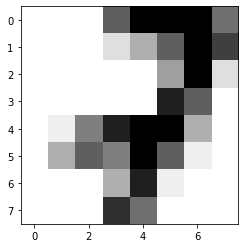


End autoencoder anomaly detection demo 



In [29]:
# 5. show most anomalous item
print("Largest reconstruction item / error: ")
(idx,err) = err_list[0]
print(" [%4d]  %0.4f" % (idx, err)) 
display_digit(data_ds, idx)

print("\nEnd autoencoder anomaly detection demo \n")

See what happens when not "normalizing" the data at the moment of computing the reconstruction error

In [30]:
result_lst = []
n_features = len(data_ds[0])  # 65
for i in range(len(data_ds)):
    X = data_ds[i]
    with T.no_grad():
        Y = autoenc(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(0, 4.374675273895264), (1, 6.587815761566162), (2, 5.3183112144470215), (3, 5.790109634399414), (4, 4.377723693847656), (5, 4.237789154052734), (6, 4.329117298126221), (7, 3.238670825958252), (8, 5.772161960601807), (9, 3.788057327270508), (10, 7.525214672088623), (11, 5.483762741088867), (12, 6.488882064819336), (13, 3.726156711578369), (14, 3.4289705753326416), (15, 5.002440929412842), (16, 4.704334259033203), (17, 6.216770172119141), (18, 3.5430381298065186), (19, 6.364357948303223), (20, 6.187163352966309), (21, 3.1908318996429443), (22, 4.120421886444092), (23, 5.251192092895508), (24, 6.2091193199157715), (25, 4.636068820953369), (26, 4.962489128112793), (27, 4.791424751281738), (28, 6.567503929138184), (29, 4.597147464752197), (30, 4.997529983520508), (31, 4.4614434242248535), (32, 5.532243728637695), (33, 4.960035800933838), (34, 6.9002203941345215), (35, 7.2606329917907715), (36, 6.270171165466309), (37, 3.6562275886535645), (38, 6.702008247375488), (39, 7.712985038757324), 

Largest reconstruction item / error: 
 [ 486]  0.1352

digit =  7 

00 00 00 0A 10 10 10 09 
00 00 00 02 05 0A 10 0C 
00 00 00 00 00 06 10 02 
00 00 00 00 00 0E 0A 00 
00 01 08 0E 10 10 05 00 
00 05 0A 08 10 0A 01 00 
00 00 00 05 0E 01 00 00 
00 00 00 0D 09 00 00 00 


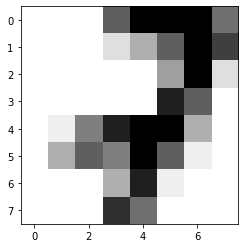


End autoencoder anomaly detection demo 



In [31]:
# 5. show most anomalous item
print("Largest reconstruction item / error: ")
(idx,err) = err_list[0]
print(" [%4d]  %0.4f" % (idx, err)) 
display_digit(data_ds, idx)

print("\nEnd autoencoder anomaly detection demo \n")

Same result as with "normalization" is obtained